Some $\LaTeX$ macros:

$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:

#%pylab inline
#%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import matplotlib.pyplot as plt


import numpy as np
import scipy.stats as stats

import pystan
import seaborn as sns
import scipy.special as sp

In [2]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Here is a more extensive example that illustrates fitting a the parameters of a Schechter galaxy luminosity function from a flux-limited galaxy survey.

The Luminosity function of galaxies is typically modelled by a Schechter function:
$$
\diff{N}{L} = \frac{\Lambda}{L_*^{1+\alpha} \Gamma\left(1+\alpha\right)} L^\alpha \exp\left[ - \frac{L}{L_*}\right]
$$
with $\alpha > -1$ and $L_*>0$ parameters controlling the shape of the distribution and $\Lambda$ the expected number of galaxies in the survey volume (i.e. the overall normalisation).

Suppose we can measure distances to galaxies perfectly, but that we typically measure fluxes (and therefore luminosities) with $\sigma_L \simeq 5\%$ uncertainty:
$$
p\left( L_\mathrm{obs} \mid L \right) = \frac{1}{\sigma_L L_\mathrm{obs} \sqrt{2\pi}} \exp\left[ - \frac{1}{2} \left(\frac{\log L - \log L_\mathrm{obs}}{\sigma_L} \right)^2\right].
$$

We want to use a flux-limited survey to infer the galaxy luminosity function.  Assume a Euclidean universe, so (in appropriate units)
$$
P_\mathrm{det} \left( L_\mathrm{obs} \right) = \begin{cases}
1 & \frac{L_\mathrm{obs}}{4 \pi z^2} > F_\mathrm{th} \\
0 & \mathrm{otherwise}
\end{cases}
$$
To make things a bit more efficient, we are going to assume that galaxies are distributed uniformly in $z$, rather than volumetrically (this will just reduce the number of low-flux galaxies we need to track in the integral, but dosen't fundamentally change the method).

We will assume that the true values of the parameters are $L_* = 1$, $\alpha = -0.5$, and choose a flux threshold so that we can just observe a $L_*$ galaxy at $z = 1$: $F_\mathrm{th} = \frac{1}{4\pi}$.  The code below draws random glaxies according to these recipes:

In [3]:
def schechter(L, alpha, Lstar):
    return L**alpha * np.exp(-L/Lstar)/(Lstar**(1+alpha) * sp.gamma(1+alpha))

In [5]:
def draw_redshift(zmax, size=1):
    return zmax*np.random.uniform(size=size)

In [6]:
def draw_luminosity(alpha, Lstar, size=1):
    xs = (1 - np.random.uniform(size=size))
    return Lstar*sp.gammaincinv(1+alpha, xs)

In [7]:
def draw_luminosity(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [8]:
def draw_fobs(L,zs, size=1):
    
    Fobs = L / (4. * np.pi * zs*zs)
    
    return np.exp(np.log(Fobs) + 0.05*np.random.randn(size))

In [9]:
def draw_survey(N, alpha, Lstar, Fth, zmax):
    n = np.random.poisson(N)
    
    Ls = draw_luminosity(alpha, Lstar, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Fobs = draw_fobs(Ls, zs,size=n)
    
    #Fobs = Lobs / (4*pi*zs*zs)
        
    sel = Fobs > Fth
    
    z99obs = np.percentile(zs[sel], 99)
    
    print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    
    return Fobs[sel], zs[sel], Ls[sel], sel.shape[0]-sum(sel)

In [10]:

def draw_survey(N, mu, sigma, Fth, zmax):
    n = np.random.poisson(N)
    
    Ls = draw_luminosity(mu, sigma, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Fobs = draw_fobs(Ls, zs,size=n)
    
    #Fobs = Lobs / (4*pi*zs*zs)
        
    sel = Fobs > Fth
    
    z99obs = np.percentile(zs[sel], 99)
    
    print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    
    return Fobs[sel], zs[sel], Ls[sel], sel.shape[0]-sum(sel)

Here we draw the observations of such a survey, and check that the highest-redshift observed galaxy is well within the maximum redshift that defines our survey volume.

In [11]:
np.random.seed(123)

Lambda_true = 100
#alpha_true = -0.5
#Lstar_true = 1.0
mu_true = 1.
sigma_true=.1
Fth = 1./(4.*np.pi)
zmax = 5
#Fobs, zobs , Ls, NNobs = draw_survey(Lambda_true, alpha_true, Lstar_true, Fth, zmax)

Fobs, zobs , Ls, NNobs = draw_survey(Lambda_true, mu_true, sigma_true, Fth, zmax)
print('Found {:d} galaxies and missed {:d} galaxies out to z = {:.1f}'.format(len(Ls), NNobs, zmax))

99th percentile of observed galaxy redshifts is 1.66
Found 33 galaxies and missed 73 galaxies out to z = 5.0


<IPython.core.display.Javascript object>


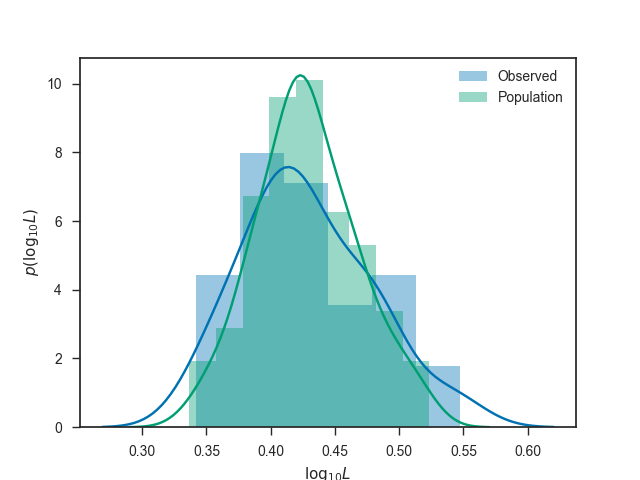

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\log_{10} L\\right)$')

In [12]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Ls), label="Observed")
sns.distplot(np.log10(draw_luminosity(mu_true, sigma_true, size=100)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} L$')
ax.set_ylabel(r'$p\left( \log_{10} L\right)$')

<IPython.core.display.Javascript object>


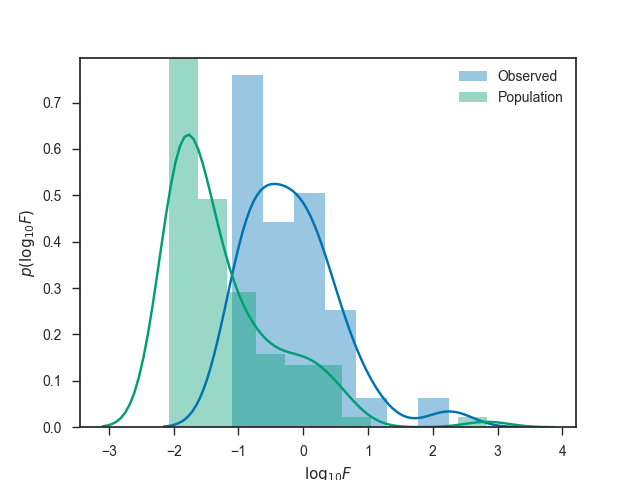

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\log_{10} F\\right)$')

In [46]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Fobs), label="Observed")

zzz= draw_redshift(zmax,size=100)
sns.distplot(np.log10(draw_fobs(draw_luminosity(mu_true, sigma_true, size=100),zzz,size=100)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} F$')
ax.set_ylabel(r'$p\left( \log_{10} F\right)$')

<IPython.core.display.Javascript object>


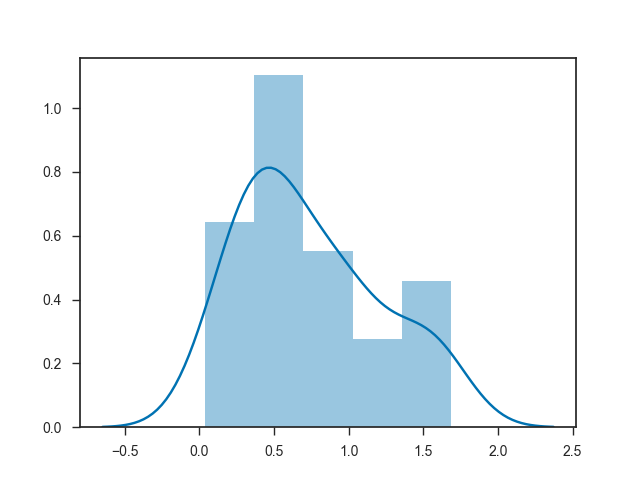

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [27]:
fig, ax = plt.subplots()

sns.distplot(zobs)


The Stan model is in the file `schechter.stan`; the method is described in the accompanying `Gaussian.ipynb` notebook (we use the mixture-model formulation that proved most efficient in that test).  Note that, unlike for the Gaussian case, there is no analytic form for 
$$
\left\langle P_\mathrm{det} \right\rangle = \int \dd z \, \dd L \, \dd L_\mathrm{obs} \, P_\mathrm{det}\left(  \frac{L_\mathrm{obs}}{4\pi z^2} \right) p\left( L_\mathrm{obs} \mid L, z \right) p\left( L \mid \alpha, L_* \right) p\left(z \right),
$$
so we have to evaluate the fraction of the population that is detected numerically.

In [31]:
model = pystan.StanModel(file='schechter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56ca1519c4ce1e99e4a7c63bf7ec6546 NOW.


As in `Gaussian.ipynb`, we choose to truncate the number of un-observed systems in the product in the likelihood at a number sufficient to encompass all the support for the number of *physical* non-observed systems; this is the `NNobs_max` parameter below.

In [32]:
fit = model.sampling(
    data = {'Nobs': len(Ls), 
            'Fobs': Fobs, 
            'zobs': zobs,
            'NNobs_max': 200,
            'Funcert': 0.05, 
            'zmax': zmax,
            'Fth':Fth},
    iter = 4000,
    thin = 2,
    seed=1234

)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


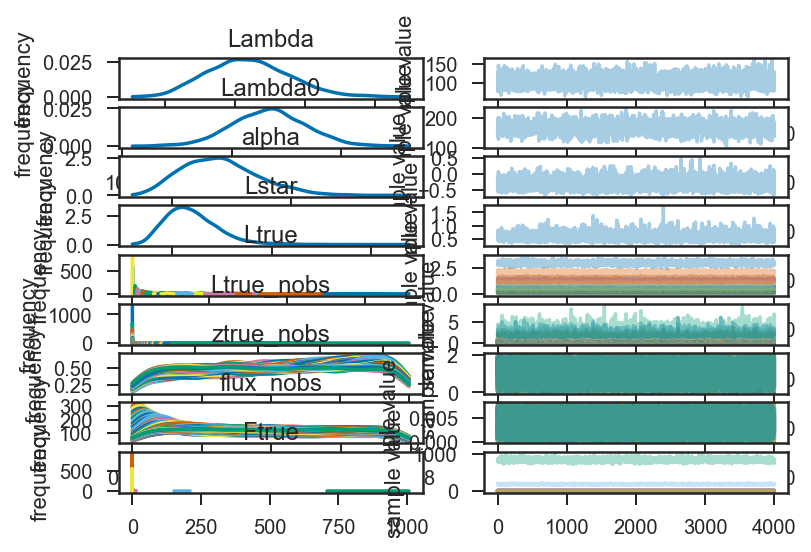

In [25]:
fit.plot();

<IPython.core.display.Javascript object>


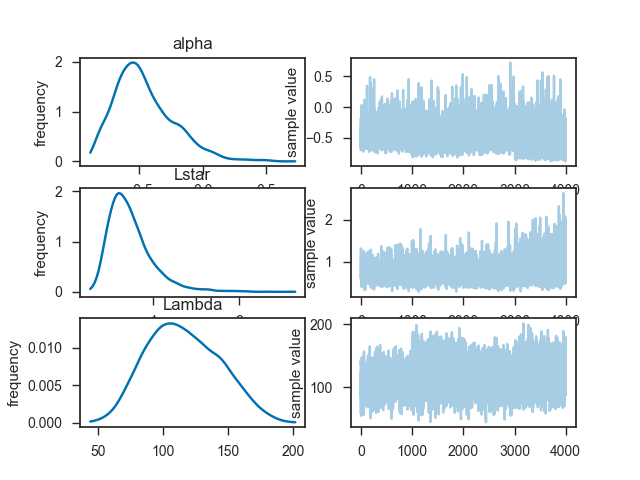

In [33]:
fit.plot(['alpha', 'Lstar', 'Lambda']);

In [34]:
chain = fit.extract(permuted=True)

Here come some 1-D marginals:

<IPython.core.display.Javascript object>


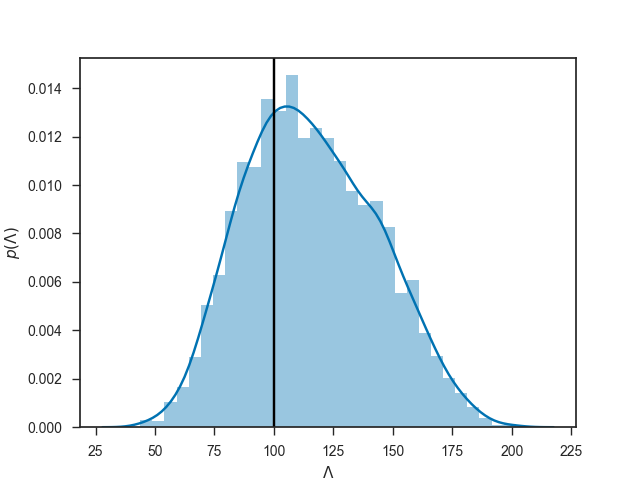

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\Lambda \\right)$')

In [36]:
fig, ax = plt.subplots()

sns.distplot(chain['Lambda'])
ax.axvline(Lambda_true, color='k')
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'$p\left( \Lambda \right)$')

<IPython.core.display.Javascript object>


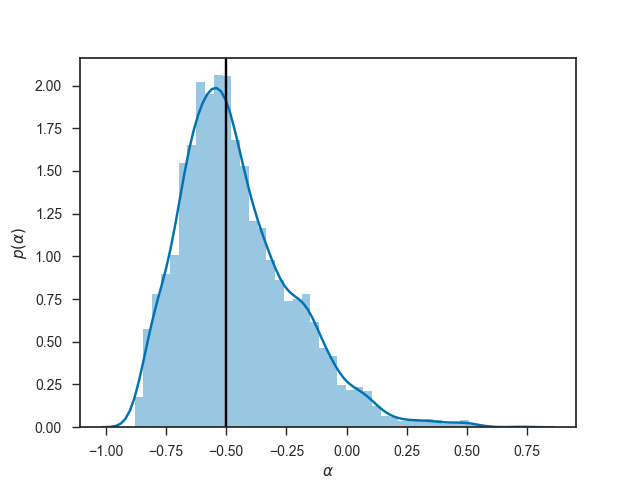

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\alpha \\right)$')

In [37]:
fig, ax = plt.subplots()

sns.distplot(chain['alpha'])
ax.axvline(alpha_true, color='k')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$p\left( \alpha \right)$')

<IPython.core.display.Javascript object>


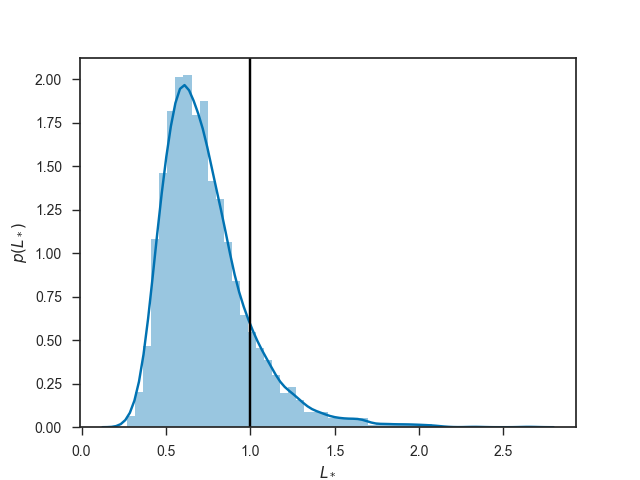

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( L_* \\right)$')

In [38]:
fig,ax = plt.subplots()

sns.distplot(chain['Lstar'])
ax.axvline(Lstar_true, color='k')
ax.set_xlabel(r'$L_*$')
ax.set_ylabel(r'$p\left( L_* \right)$')

And the 2D posterior on the shape parameters for the galaxy luminosity function:

<IPython.core.display.Javascript object>


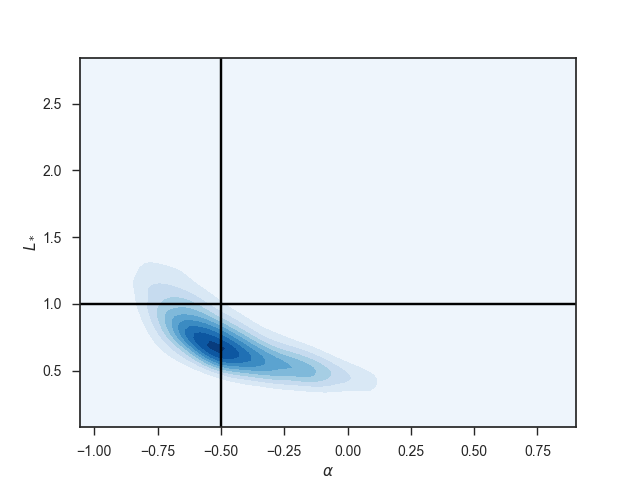

Text(0,0.5,'$L_*$')

In [39]:
fig, ax = plt.subplots()

sns.kdeplot(chain['alpha'], chain['Lstar'], shade=True, cmap='Blues')
ax.axvline(alpha_true, color='k')
ax.axhline(Lstar_true, color='k')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$L_*$')

A pretty 1D plot of the inferred galaxy LF (grey) compared to the inverse-detection-efficiency-at-bin-centre-weighted histogram estimator.  Not bad!

<IPython.core.display.Javascript object>


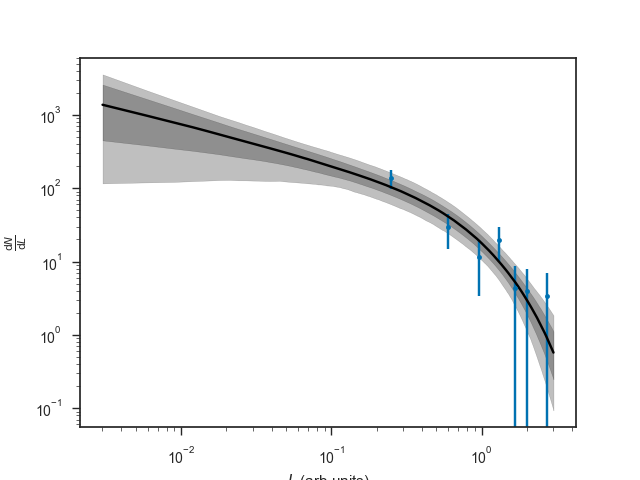

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0,0.5,'$\\frac{\\mathrm{d}N}{\\mathrm{d}L}$')

In [44]:
fig, ax = plt.subplots()

Ls_eval = np.linspace(0, 3, 1000)[1:]
LFs = []
for L, alpha, Lstar in zip(chain['Lambda'], chain['alpha'], chain['Lstar']):
    LFs.append(L*schechter(Ls_eval, alpha, Lstar))
LFs = np.array(LFs)
ax.plot(Ls_eval, np.median(LFs, axis=0), color='k')
ax.fill_between(Ls_eval, np.percentile(LFs, 84, axis=0), np.percentile(LFs, 16, axis=0), color='k', alpha=0.25)
ax.fill_between(Ls_eval, np.percentile(LFs, 97.5, axis=0), np.percentile(LFs, 2.5, axis=0), color='k', alpha=0.25)

cts, bins = np.histogram(Ls, bins=8)
dndl = cts / np.diff(bins) / (np.sqrt(0.5*(bins[1:]+bins[:-1])/(4*np.pi*Fth))/zmax)

ax.errorbar(0.5*(bins[1:]+bins[:-1]), dndl, dndl/np.sqrt(cts), fmt='.')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$L$ (arb units)')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}L}$')

## Via direct marignalization

In [16]:
model_marginal = pystan.StanModel(file='schechter_marginal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c68cfcce4ccab1ff84865003fbe5052a NOW.


In [29]:
fit = model_marginal.sampling(
    data = {'Nobs': len(Ls), 
            'Fobs': Fobs,
            'zobs': zobs,
            'NNobs_max': 1000, 
            'Funcert': 0.05, 
            'zmax': 2,
            'Fth': Fth},
    iter = 8000,
    chains=4,
    #warmup=4000,
    thin = 4,
    seed=1234
)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


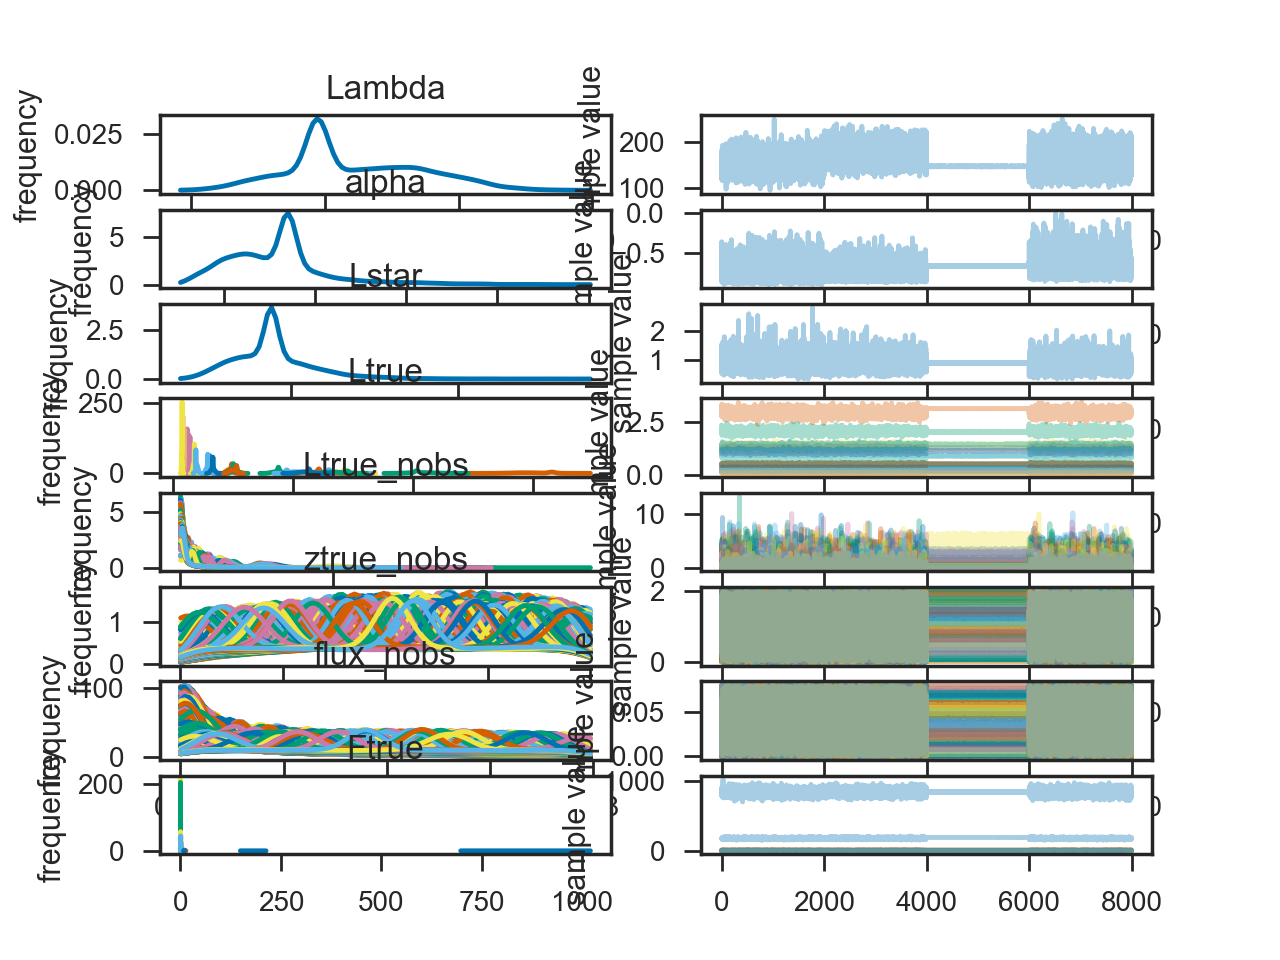

In [28]:
fit.plot();

<IPython.core.display.Javascript object>


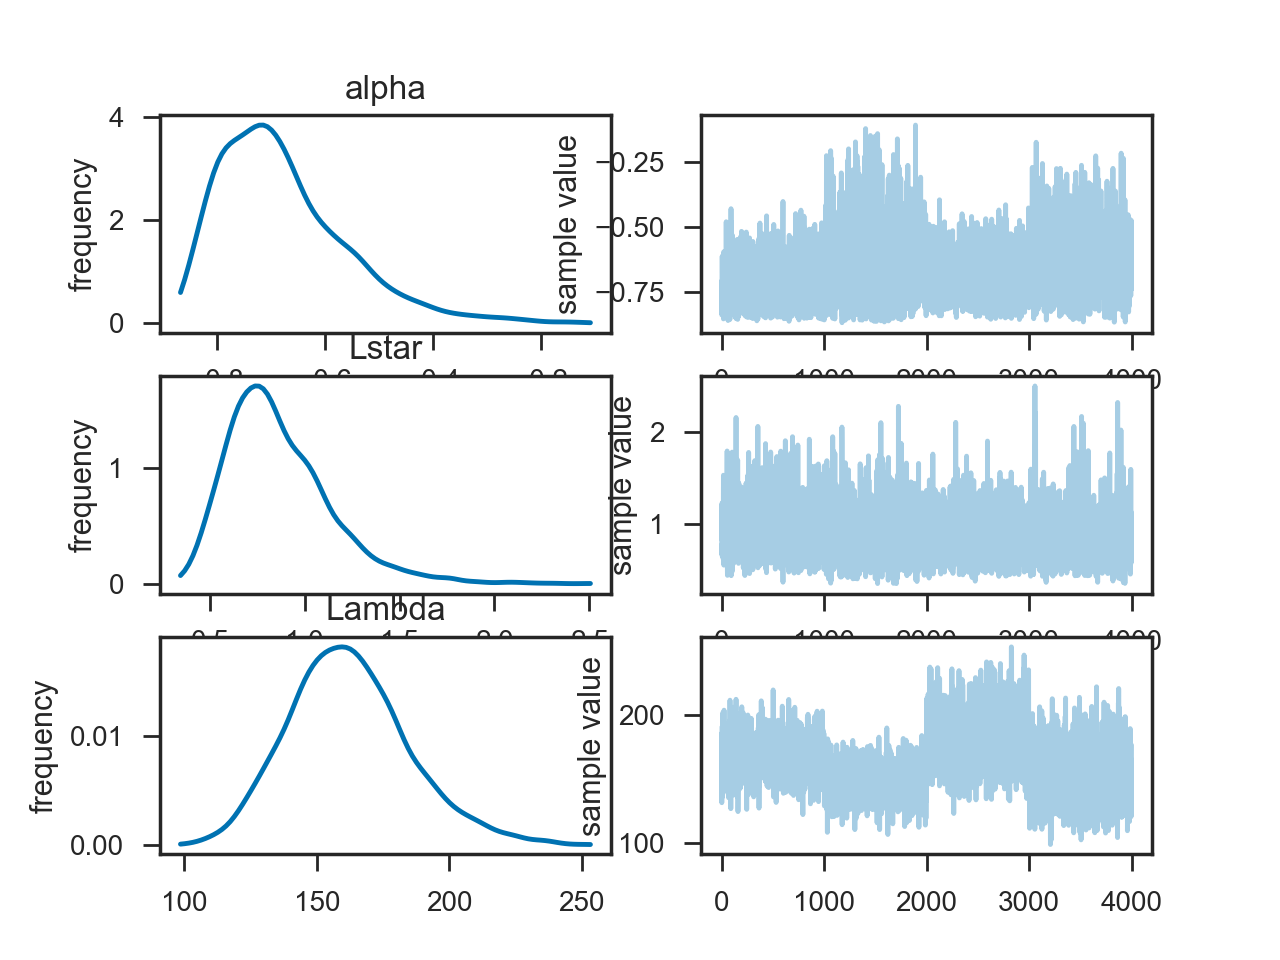

In [30]:
fit.plot(['alpha', 'Lstar', 'Lambda']);

In [31]:
chain = fit.extract(permuted=True)

<IPython.core.display.Javascript object>


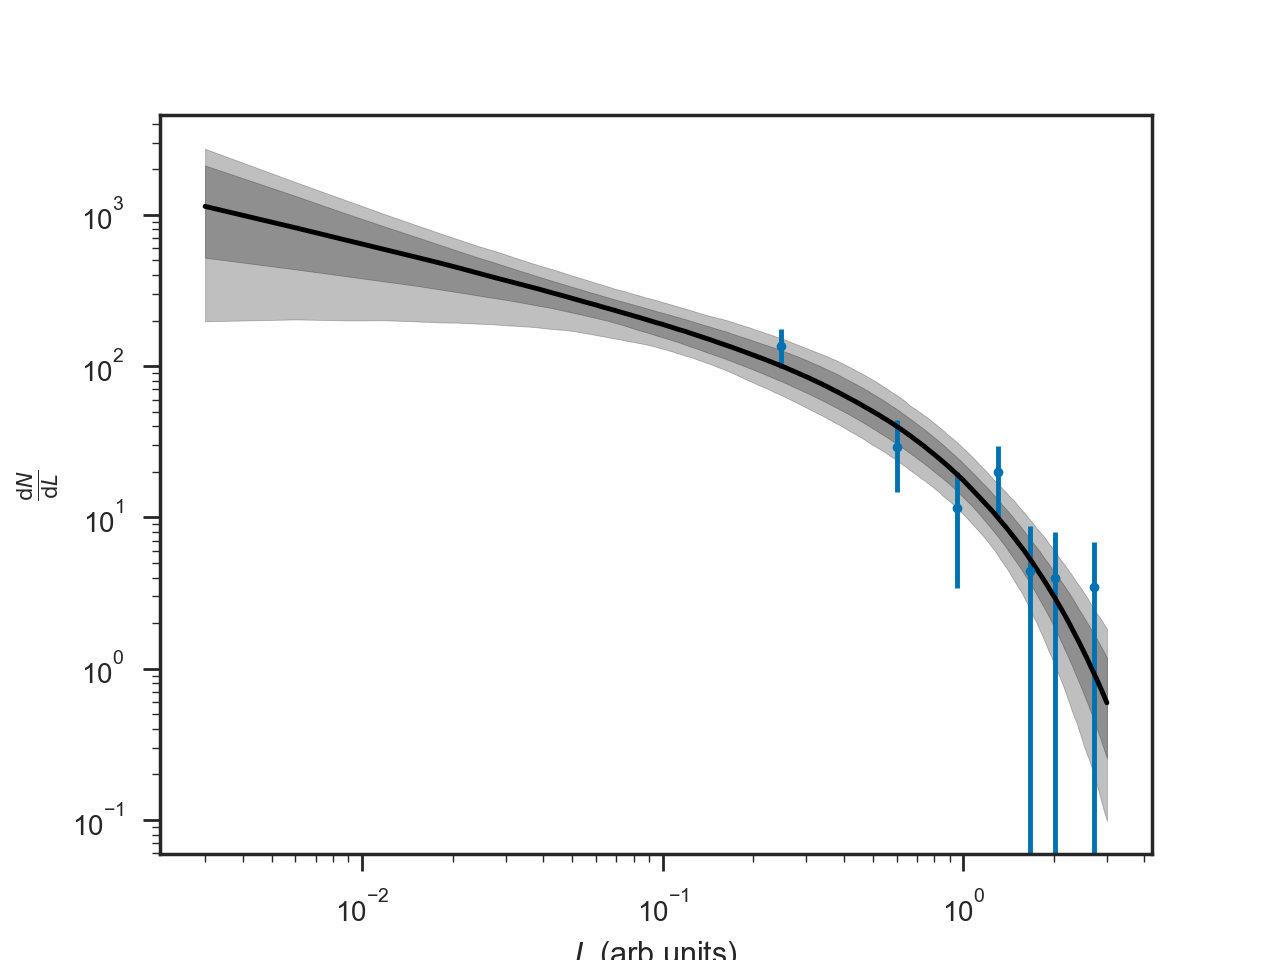

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0,0.5,'$\\frac{\\mathrm{d}N}{\\mathrm{d}L}$')

In [20]:
fig, ax = plt.subplots()

Ls_eval = np.linspace(0, 3, 1000)[1:]
LFs = []
for L, alpha, Lstar in zip(chain['Lambda'], chain['alpha'], chain['Lstar']):
    LFs.append(L*schechter(Ls_eval, alpha, Lstar))
LFs = np.array(LFs)
ax.plot(Ls_eval, np.median(LFs, axis=0), color='k')
ax.fill_between(Ls_eval, np.percentile(LFs, 84, axis=0), np.percentile(LFs, 16, axis=0), color='k', alpha=0.25)
ax.fill_between(Ls_eval, np.percentile(LFs, 97.5, axis=0), np.percentile(LFs, 2.5, axis=0), color='k', alpha=0.25)

cts, bins = np.histogram(Ls, bins=8)
dndl = cts / np.diff(bins) / (np.sqrt(0.5*(bins[1:]+bins[:-1])/(4*np.pi*Fth))/zmax)

ax.errorbar(0.5*(bins[1:]+bins[:-1]), dndl, dndl/np.sqrt(cts), fmt='.')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$L$ (arb units)')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}L}$')

<IPython.core.display.Javascript object>


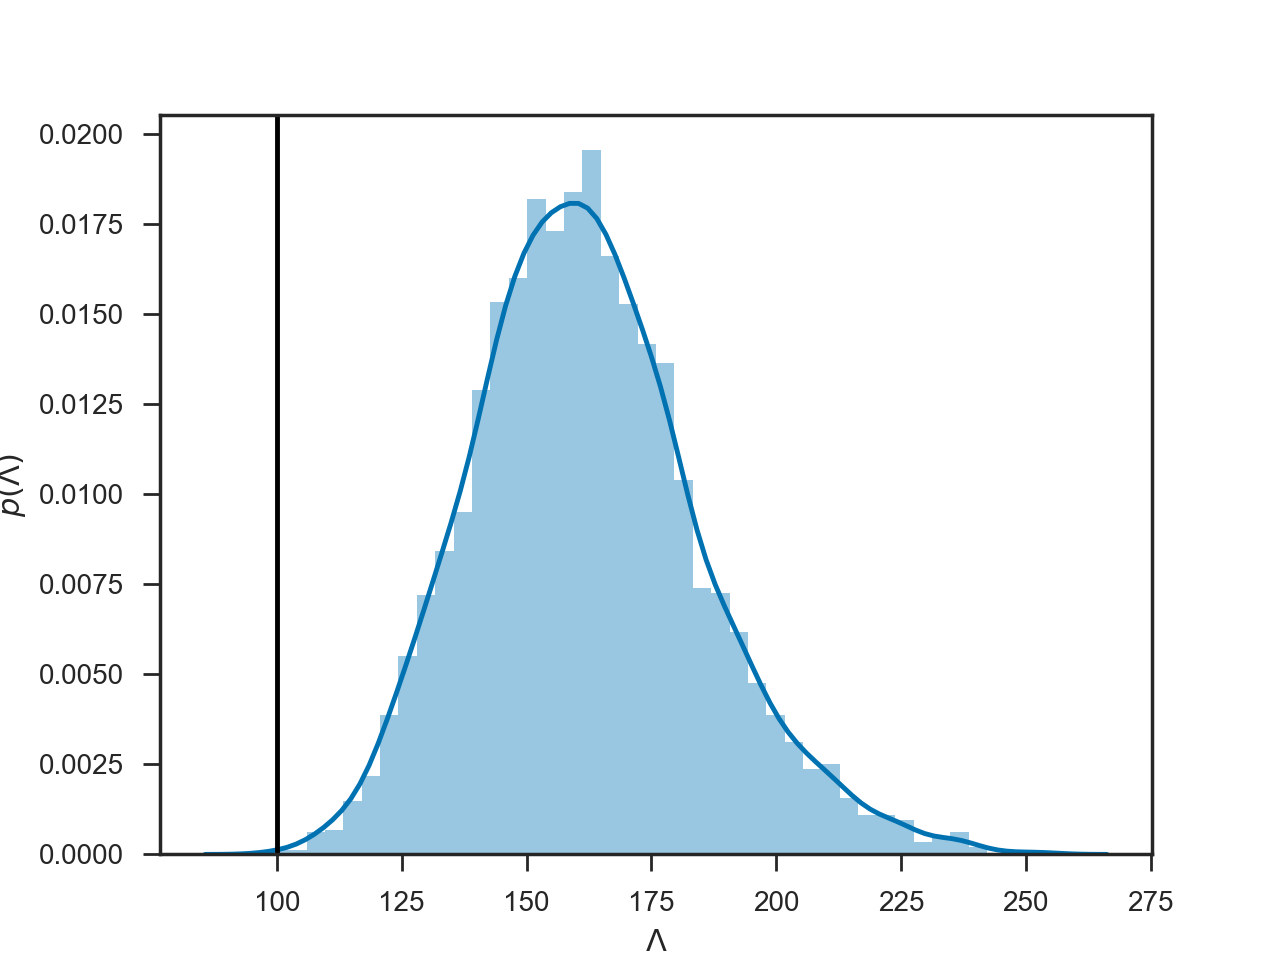

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\Lambda \\right)$')

In [32]:
fig, ax = plt.subplots()

sns.distplot(chain['Lambda'])
ax.axvline(Lambda_true, color='k')
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'$p\left( \Lambda \right)$')

<IPython.core.display.Javascript object>


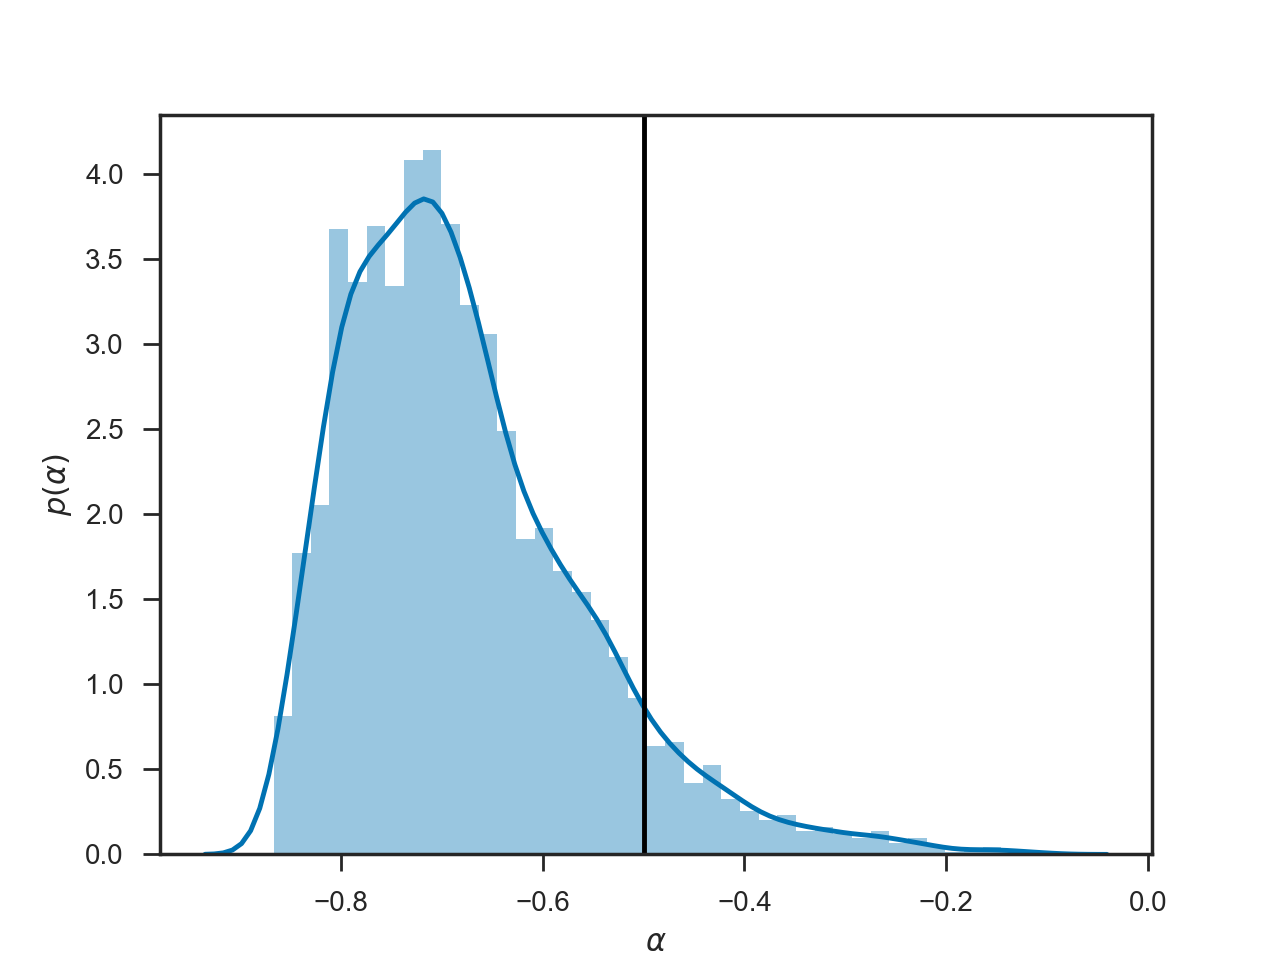

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\alpha \\right)$')

In [33]:
fig, ax = plt.subplots()

sns.distplot(chain['alpha'])
ax.axvline(alpha_true, color='k')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$p\left( \alpha \right)$')

<IPython.core.display.Javascript object>


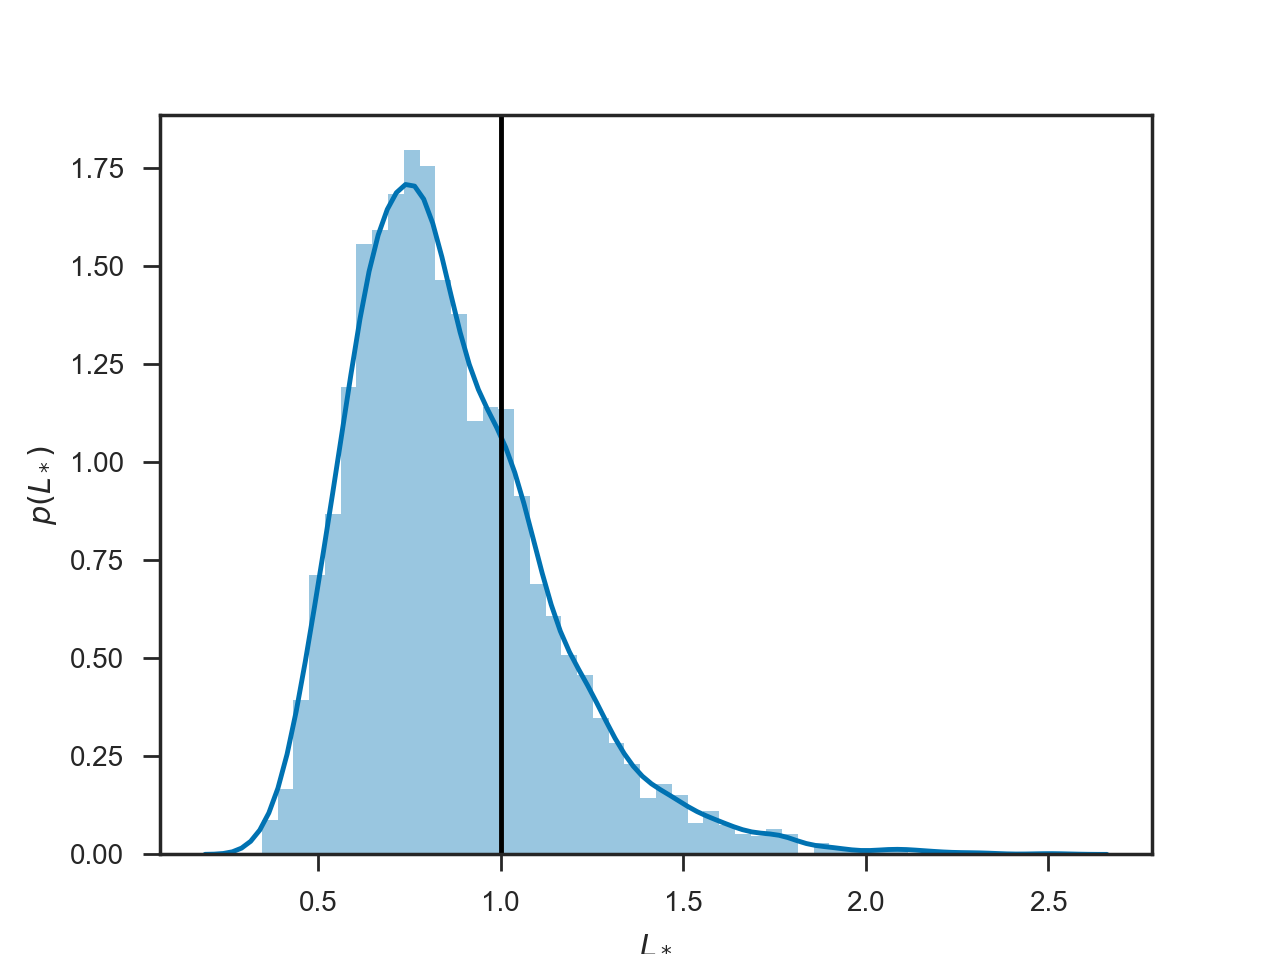

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( L_* \\right)$')

In [34]:
fig,ax = plt.subplots()

sns.distplot(chain['Lstar'])
ax.axvline(Lstar_true, color='k')
ax.set_xlabel(r'$L_*$')
ax.set_ylabel(r'$p\left( L_* \right)$')

<IPython.core.display.Javascript object>


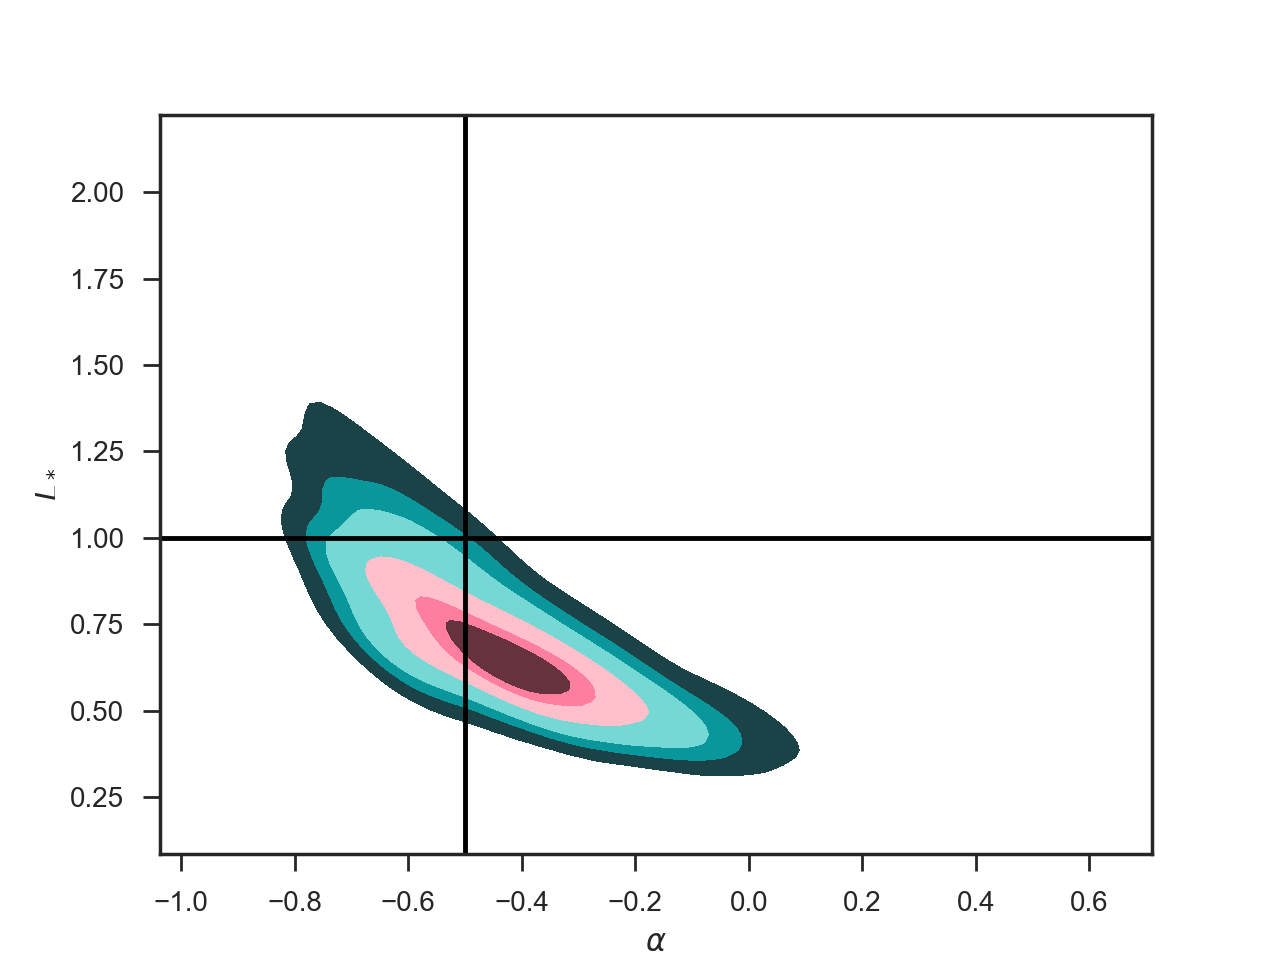

Text(0,0.5,'$L_*$')

In [23]:
from vapeplot import vapeplot

fig, ax = plt.subplots()

sns.kdeplot(chain['alpha'], chain['Lstar'], shade=True,shade_lowest=False, cmap=vapeplot.cmap('macplus'))
ax.axvline(alpha_true, color='k')
ax.axhline(Lstar_true, color='k')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$L_*$')

In [35]:
fit

Inference for Stan model: anon_model_c68cfcce4ccab1ff84865003fbe5052a.
4 chains, each with iter=8000; warmup=4000; thin=4; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda          162.13    8.02  22.67 122.08 146.45 160.78 175.97 212.14      8   1.56
alpha            -0.68    0.02   0.12  -0.84  -0.76   -0.7  -0.62  -0.38     28   1.17
Lstar             0.86    0.03   0.27   0.47   0.67   0.81   1.01   1.53     88   1.04
Ltrue[0]           0.3  2.6e-4   0.02   0.28   0.29    0.3   0.31   0.33   3523    1.0
Ltrue[1]          0.87  7.2e-4   0.04   0.79   0.84   0.87    0.9   0.96   3604    1.0
Ltrue[2]          0.47  3.8e-4   0.02   0.42   0.45   0.47   0.48   0.51   3718    1.0
Ltrue[3]          0.12  9.7e-5 5.9e-3   0.11   0.11   0.12   0.12   0.13   3635    1.0
Ltrue[4]          1.39  1.1e-3   0.07   1.26   1.35   1.39   1.44   1.53   4000    1.0
Ltrue[5]          0.29  2.4e

In [70]:
model_marginal_norm = pystan.StanModel(file='gaussian_z.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0cbda65717affc2117cc9b8677bd0140 NOW.


In [78]:
fit_gz = model_marginal_norm.sampling(
    data = {'Nobs': len(Ls), 
            'Fobs': Fobs,
            'zobs': zobs,
            'NNobs_max': 500, 
            'Funcert': 0.05, 
            'zmax': zmax,
            'Fth': Fth},
    iter = 32000,
    chains=4,
    #warmup=4000,
    thin = 8,
    seed=1234
)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


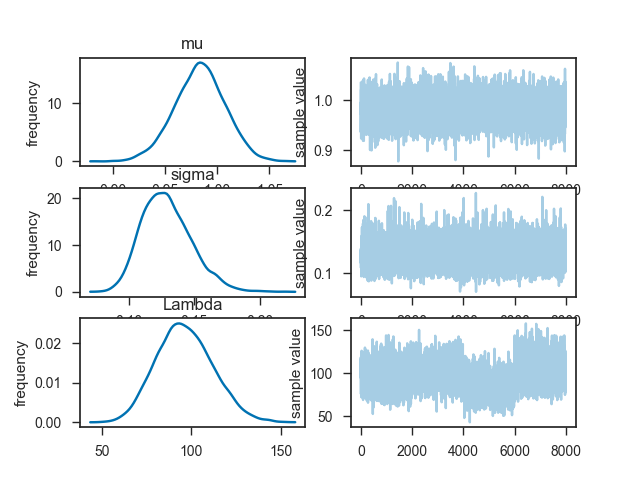

In [79]:
fit_gz.plot(['mu', 'sigma', 'Lambda']);

<IPython.core.display.Javascript object>


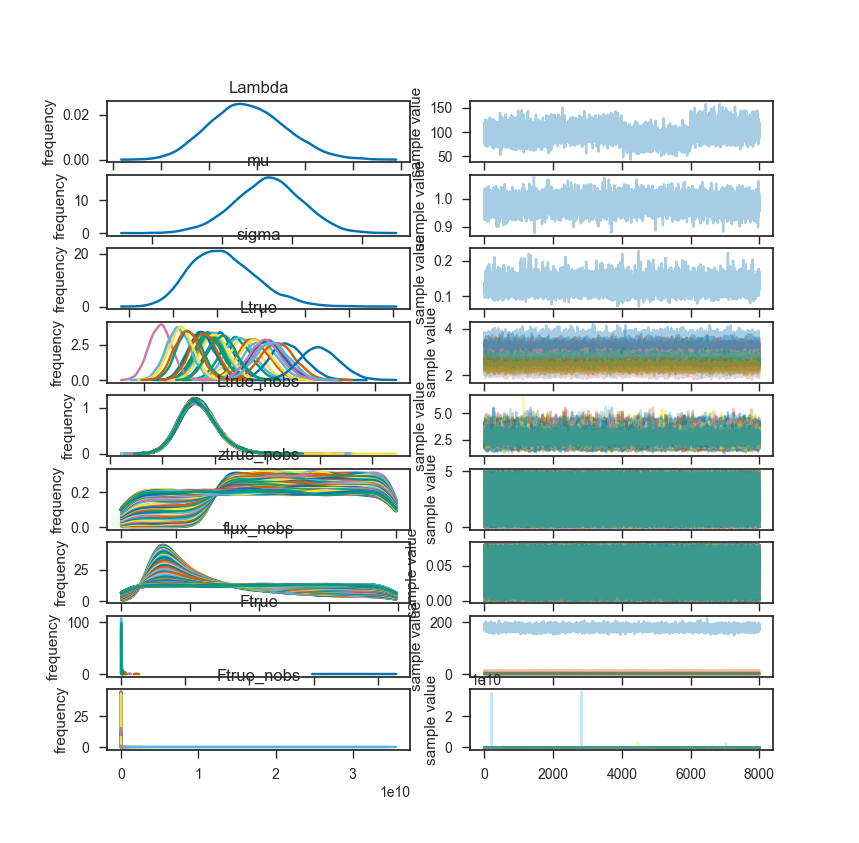

In [81]:
fit_gz.plot();

<IPython.core.display.Javascript object>


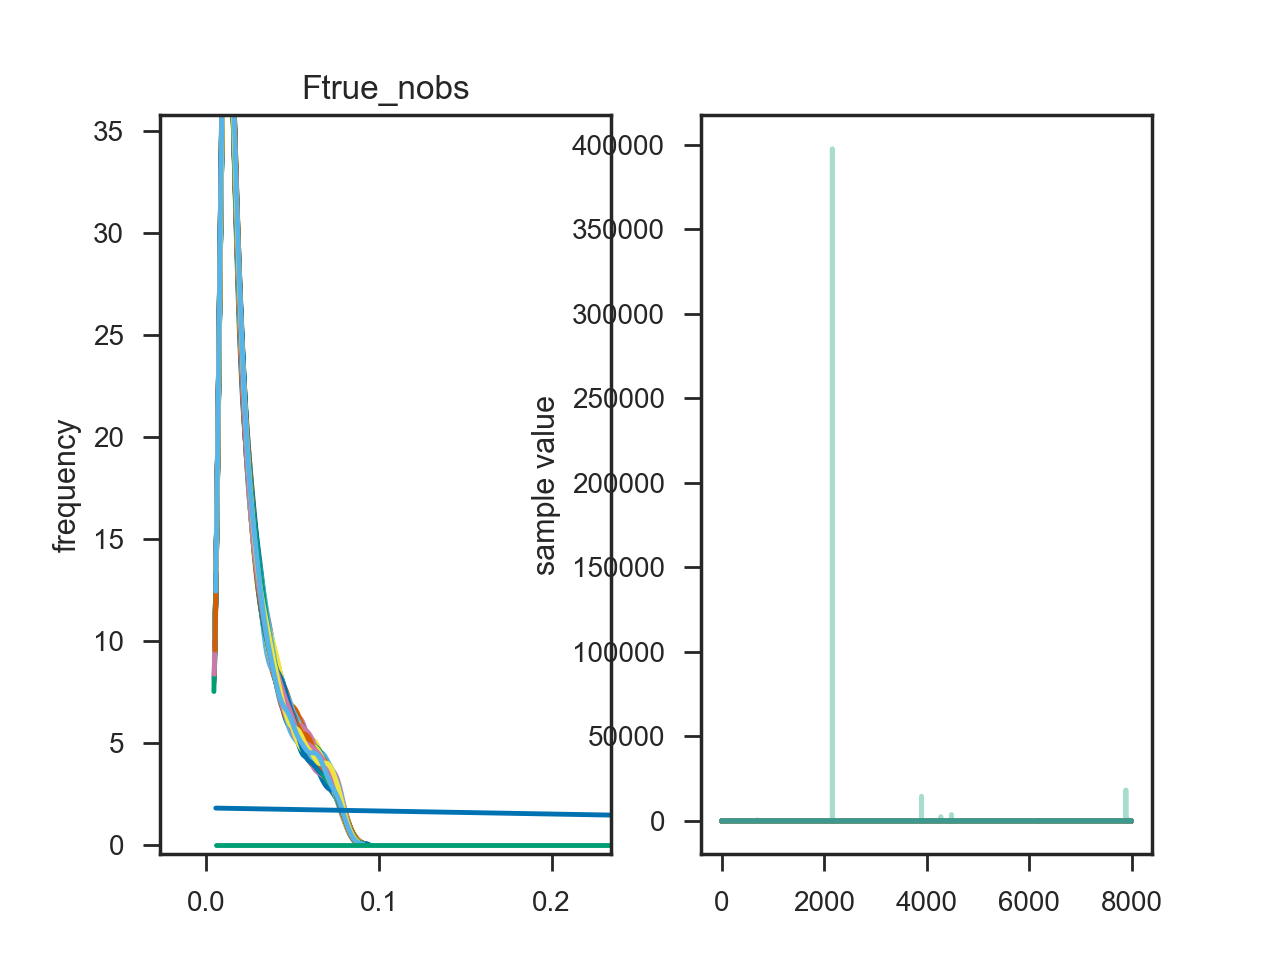

In [42]:
fit_gz.plot(['Ftrue_nobs']);

In [80]:
fit_gz

Inference for Stan model: anon_model_0cbda65717affc2117cc9b8677bd0140.
4 chains, each with iter=32000; warmup=16000; thin=8; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda           96.31    5.94  15.72  67.66  85.42  95.52 106.74 128.51      7   1.28
mu                0.98  4.0e-4   0.02   0.93   0.97   0.98    1.0   1.03   3720    1.0
sigma             0.13  4.6e-4   0.02    0.1   0.12   0.13   0.14   0.17   1683    1.0
Ltrue[0]          2.66  1.4e-3   0.12   2.43   2.58   2.66   2.74   2.91   7900    1.0
Ltrue[1]           2.5  1.3e-3   0.12   2.28   2.42   2.49   2.57   2.73   8000    1.0
Ltrue[2]           2.6  1.4e-3   0.12   2.37   2.52    2.6   2.68   2.85   7918    1.0
Ltrue[3]          2.68  1.4e-3   0.12   2.45   2.59   2.68   2.76   2.93   8000    1.0
Ltrue[4]          2.88  1.5e-3   0.13   2.62   2.79   2.87   2.97   3.15   8000    1.0
Ltrue[5]          3.01  1.

In [60]:
(np.pi * 4)

12.566370614359172